# **Étude du papier de recherche**
## *A Unified Framework for U-Net Design and Analysis*

Ce notebook s’inscrit dans le cadre du projet du cours *Generative Models & Simulation* (Master MS2A, Sorbonne Université). Il a pour objectif d’étudier de manière rigoureuse l’article **“A Unified Framework for U-Net Design and Analysis”**, qui propose un cadre mathématique unifié pour la définition, l’analyse et la comparaison des architectures de type U-Net.

Conformément aux consignes du projet, ce travail poursuit les objectifs suivants :

- **Présenter le contexte de l’article**, en explicitant le problème étudié, les types de données considérés, les limites des approches existantes et les apports théoriques et méthodologiques du papier, dans un cadre mathématiquement rigoureux.
- **Décrire clairement la méthode proposée par les auteurs**, en mettant en évidence les idées structurantes du formalisme unifié et les mécanismes clés des architectures U-Net.
- **Adopter une approche algorithmique**, en implémentant une version simplifiée mais fidèle du cadre proposé, afin d’en étudier le comportement et les propriétés sur des données contrôlées.
- **Valider expérimentalement la méthode**, d’abord sur des **données synthétiques** soigneusement construites pour isoler les effets des différentes briques architecturales, puis sur des **données réelles**, afin d’illustrer la pertinence du cadre dans un contexte plus applicatif.
- **Discuter rigoureusement les performances**, en analysant l’impact des choix d’implémentation et des hyperparamètres à la lumière des résultats théoriques présentés dans l’article.

Le notebook est structuré de manière progressive : après la présentation du contexte et du cadre théorique, les concepts sont traduits en une implémentation concrète, puis analysés expérimentalement à travers plusieurs expériences ciblées.

**Auteurs :** Pierre Fontbonne & Erwan Ouabdesselam

In [ ]:
# Imports 
import torch
import matplotlib.pyplot as plt

from src.data.signal_1d import Signal1DConfig, generate_pair, Signal1DDataModule
from src.metrics import mse, mse_lf_hf
import os
from src.analysis.training_curves import plot_val_loss_overlay, plot_train_val_per_model
from src.analysis.checkpoints import load_best_models
from src.analysis.reconstruction_analysis import (
    fixed_batch,
    plot_recons_clean,
    eval_models_lf_hf,
    plot_lf_hf_bars,
)


## **1. Contexte et problématique de l’article**

### **1.1. Pourquoi s’intéresser aux architectures U-Net ?**

Les U-Nets sont devenus des architectures standards dès que l’entrée et la sortie partagent une structure spatiale comparable (segmentation, reconstruction, débruitage, modèles génératifs). Leur efficacité repose principalement sur une organisation **multi-échelles** : une partie descendante qui compresse l’information et une partie montante qui reconstruit, avec des **skip connections** qui réinjectent des détails locaux.

Malgré cet usage massif, leur compréhension reste souvent empirique : on sait qu’ils marchent, mais il est plus difficile d’identifier précisément quelles briques portent les gains, et dans quelles conditions.

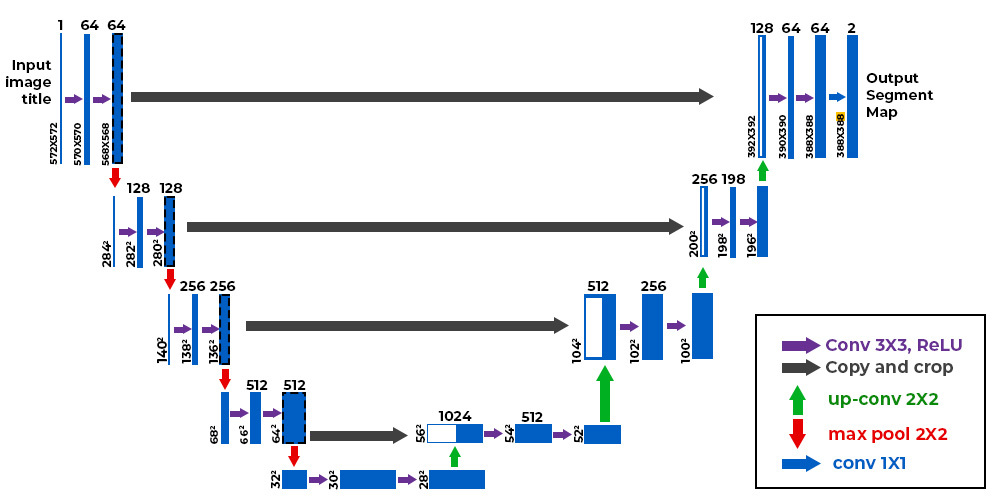

### **1.2. Problème étudié dans l’article**

L’article cherche à répondre à une question structurante : **comment définir un U-Net de manière abstraite**, indépendamment d’un choix particulier de convolutions, de pooling ou de dimensions, afin d’en analyser rigoureusement les propriétés ?

L’objectif est de disposer d’un langage commun permettant :
- de comparer des variantes sur une base cohérente ;
- d’analyser le comportement lorsque la résolution augmente (raffinement des échelles) ;
- et de relier les choix multi-échelles à des phénomènes mesurables (stabilité, transfert d’information entre fréquences, interprétation résiduelle).

### **1.3. Types de données et cadres applicatifs**

Le formalisme proposé est volontairement général : les données sont vues comme des fonctions (ou champs) sur un domaine $X$, ce qui couvre naturellement les grilles régulières (images, volumes) mais aussi des cadres plus généraux.

Cette généralité vise notamment des tâches où l’on apprend des opérateurs (reconstruction, débruitage, approximation d’opérateurs liés à des PDE) et des architectures U-Net utilisées dans les modèles de diffusion.

### **1.4. Limites des approches existantes**

Avant ce travail, la littérature propose surtout des analyses partielles : certaines portent sur des variantes spécifiques, d’autres restent au niveau architectural sans isoler clairement les mécanismes responsables des performances.

Sans cadre unifié, il est difficile :
- de comparer proprement des U-Nets très différents ;
- de relier la structure multi-échelles à des propriétés analytiques ;
- ou d’intégrer explicitement des choix liés à la géométrie ou à la physique du problème.

### **1.5. Contributions principales de l’article**

Le papier apporte trois résultats structurants.

1. **Définition unifiée des U-Nets.** Les auteurs formalisent l’architecture en termes d’opérateurs multi-échelles, ce qui clarifie la logique “descente–montée” et permet d’analyser le comportement lorsque la résolution se raffine.

2. **Multi-ResNets.** Ils introduisent une classe d’architectures où l’encodeur est associé à une décomposition multi-résolution (ondelettes orthogonales). Cela permet de séparer ce qui relève de la représentation (fixée) et ce qui relève de l’apprentissage (porté par les parties apprises), et d’injecter des structures a priori.

3. **Analyse fréquentielle (diffusion, base de Haar).** Ils montrent que, dans ce cadre, les composantes haute fréquence deviennent dominées par le bruit plus tôt que les basses fréquences, ce qui donne une justification théorique à certains choix multi-échelles (notamment des opérateurs de type low-pass/average pooling) dans les U-Nets utilisés en diffusion.

## **2. Cadre méthodologique proposé**

Cette section présente le cadre abstrait introduit dans l’article pour définir et analyser les architectures de type U-Net. L’objectif n’est pas de décrire une implémentation particulière, mais de formaliser les U-Nets comme des opérateurs multi-échelles agissant entre des espaces structurés.

### **2.1. Définition abstraite d’un U-Net**

Soient $V$ et $W$ deux espaces mesurables, représentant respectivement l’espace d’entrée et l’espace de sortie.  
Un **U-Net** est défini comme une collection d’espaces et d’opérateurs
$$
\mathcal U = (\mathcal V, \mathcal W, \mathcal E, \mathcal D, \mathcal P, U_0),
$$
où les composantes suivantes sont introduites.

#### **Sous-espaces de résolution finie**

- $\mathcal V = (V_i)_{i \ge 0}$ est une suite croissante de sous-espaces de $V$, telle que
$$
\lim_{i \to \infty} V_i = V.
$$

- $\mathcal W = (W_i)_{i \ge 0}$ est une suite croissante de sous-espaces de $W$, telle que
$$
\lim_{i \to \infty} W_i = W.
$$

Ces suites modélisent des **approximations de résolution croissante** des espaces fonctionnels continus.  
Un U-Net n’agit donc jamais directement sur $V$ et $W$, mais sur leurs projections successives.

#### **Opérateurs d’encodage et de projection**

- Les opérateurs d’encodage $\mathcal E = (E_i)_{i \ge 0}$ sont définis par
$$
E_i : V_i \to V_i, \qquad v_i \mapsto \tilde v_i.
$$

- Les opérateurs de projection $\mathcal P = (P_i)_{i \ge 0}$ satisfont
$$
P_i : V \to V_i, \qquad P_i(v_i) = v_i \quad \text{pour tout } v_i \in V_i.
$$

Les projections fixent la structure multi-échelles de départ, tandis que les encodeurs modélisent des corrections apprises à chaque niveau de résolution.

#### **Opérateurs de décodage et connexions de saut**

- Les opérateurs de décodage $\mathcal D = (D_i)_{i \ge 1}$ sont définis par
$$
D_i : W_{i-1} \times V_i \to W_i,
$$
où la variable $v_i$ correspond à la **connexion de saut** (*skip connection*).

#### **Goulot d’étranglement**

- L’opérateur
$$
U_0 : V_0 \to W_0
$$
représente le niveau de résolution le plus grossier et constitue le **bottleneck** de l’architecture.



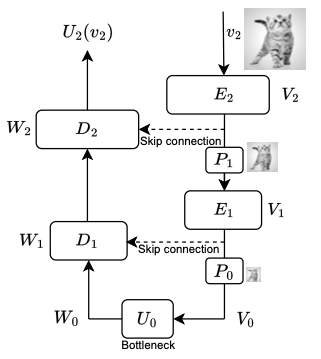

### **2.2. Définition récursive de l’opérateur U-Net**

À partir de ces briques, l’opérateur U-Net à la résolution $i$ est défini récursivement par
$$
U_i : V_i \to W_i,
$$
avec
$$
U_i(v_i) = D_i\bigl(U_{i-1}(P_{i-1}(\tilde v_i)) \mid \tilde v_i\bigr),
\qquad i \ge 1.
$$

Cette relation met en évidence une **structure hiérarchique auto-similaire** : chaque niveau affine la sortie produite à la résolution précédente en intégrant des informations de résolution plus fine via les connexions de saut.

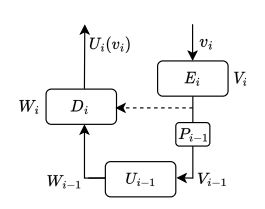

### **2.3. Interprétation et portée de la définition**

Cette formalisation abstraite permet de considérer les U-Nets comme des **approximations multi-échelles d’opérateurs définis sur des espaces fonctionnels**, plutôt que comme de simples architectures encodeur–décodeur.

Un point central est la dissociation claire entre :
- la **structure multi-échelles**, imposée par le choix des sous-espaces $(V_i)$ et des projections $(P_i)$,
- et les **opérateurs appris**, qui corrigent et affinent cette structure à chaque niveau.

Cette distinction est essentielle pour l’analyse théorique développée dans l’article, notamment lorsque la résolution tend vers l’infini.

### **2.4. Lien avec les architectures résiduelles**

Dans ce cadre, les auteurs montrent qu’un U-Net peut être interprété comme une **architecture résiduelle multi-échelles**.  
À chaque niveau $i$, l’opérateur $U_i$ apprend une correction par rapport à l’approximation fournie par $U_{i-1}$.

Autrement dit, le passage d’une résolution à une autre peut être vu comme l’apprentissage d’un terme résiduel, l’approximation grossière servant de référence.  
Cette interprétation fournit une justification théorique à l’usage généralisé de blocs résiduels dans les architectures U-Net modernes et éclaire leur stabilité empirique.

### **2.5. Choix des sous-espaces comme a priori de modélisation**

Un apport important du papier est de souligner que le choix de la suite de sous-espaces $\mathcal V$ constitue en lui-même un **a priori de modélisation**.  
Ce choix impose une décomposition multi-échelles initiale, indépendamment de l’apprentissage.

Dans cette perspective, l’encodeur n’a pas pour rôle de construire la hiérarchie de résolutions, mais d’en corriger les insuffisances lorsque celle-ci n’est pas parfaitement adaptée au problème considéré.  
Cette observation conduit naturellement à la classe des **Multi-ResNets**, dans lesquels la structure multi-échelles est entièrement fixée (par exemple via une base d’ondelettes), et où les opérateurs appris interviennent uniquement comme corrections résiduelles.

## **3. Étude expérimentale sur données synthétiques**

Afin d’illustrer concrètement le cadre théorique introduit dans la section précédente, nous menons une série d’expérimentations sur des données synthétiques contrôlées.  
L’objectif n’est pas d’optimiser des performances sur un jeu de données réaliste, mais de **mettre en évidence, dans un cadre simplifié**, le rôle des différentes briques structurelles mises en avant dans l’article.

### **3.1. Motivation générale**

Le cadre unifié proposé par les auteurs suggère que certaines composantes des architectures U-Net jouent un rôle fondamental indépendamment des détails d’implémentation.  
En particulier, deux mécanismes sont mis en avant de manière récurrente :

- le **préconditionnement multi-échelles**, induit par le choix des projections et des sous-espaces,
- les **connexions de saut**, qui permettent d’injecter des informations de résolution fine lors de la reconstruction.

Les expérimentations présentées ci-dessous visent à isoler et analyser ces deux mécanismes, en s’appuyant sur des signaux 1D synthétiques pour lesquels la structure fréquentielle est parfaitement maîtrisée.

### **3.2. Données synthétiques utilisées**

Les expériences présentées dans cette partie reposent sur des **signaux unidimensionnels synthétiques** définis sur un intervalle discret de longueur $L = 512$.  
Ce choix permet de travailler dans un cadre entièrement contrôlé, tout en conservant une structure multi-échelles suffisamment riche pour analyser les mécanismes mis en avant dans l’article.

Chaque signal propre $x \in \mathbb{R}^L$ est construit comme une superposition de composantes élémentaires, activables indépendamment :
- **composantes globales lisses**, modélisées par des sommes de sinusoïdes (basses fréquences),
- **discontinuités intermédiaires** de type *steps*,
- **événements localisés** de type *spikes*.

À partir de ces signaux propres, une observation bruitée $y$ est générée par ajout d’un bruit additif :
$$
y = x + \varepsilon,
$$
où $\varepsilon$ regroupe différentes sources de bruit aléatoire.  
Le problème étudié est ainsi formulé comme un **problème de débruitage supervisé**, visant à approximer l’opérateur inverse $y \mapsto x$.

Ce cadre, volontairement simple, permet néanmoins de combiner structures globales et locales, ce qui en fait un terrain d’étude adapté à l’analyse d’architectures multi-échelles de type U-Net.

#### **Contrôle de la structure et de la difficulté**

La génération des signaux est paramétrée via la classe `Signal1DConfig`, qui permet de contrôler explicitement :
- la longueur du signal,
- la présence de discontinuités et d’événements localisés,
- l’intensité du bruit,
- ainsi que la normalisation des données.

Cette paramétrisation modulaire permet :
- de faire varier progressivement la difficulté du problème,
- de tester la robustesse des architectures étudiées,
- et de garantir des comparaisons équitables entre modèles, tous entraînés sur des données générées selon les mêmes règles.

L’ensemble des jeux de données est généré de manière **déterministe à graine fixée**, assurant une reproductibilité complète des expériences.



#### **Analyse fréquentielle des erreurs**

Afin d’interpréter plus finement les performances des modèles, les erreurs de reconstruction sont également analysées dans une base fréquentielle.

Une décomposition de type Haar est utilisée pour séparer chaque signal en :
- une composante basse fréquence (LF),
- une composante haute fréquence (HF).

Pour un signal reconstruit $\hat{x}$ et un signal cible $x$, on définit :
$$
x_{\mathrm{LF}} = \mathcal{H}(x), \qquad x_{\mathrm{HF}} = x - x_{\mathrm{LF}},
$$
où $\mathcal{H}$ désigne l’opérateur de reconstruction basse fréquence associé à la base de Haar.

Cette décomposition permet de distinguer la capacité des modèles à reconstruire la structure globale du signal de leur comportement sur les détails locaux.  
Elle est directement exploitée dans l’analyse des expériences A et B, en lien avec les notions de préconditionnement et de propagation multi-échelles introduites dans l’article.

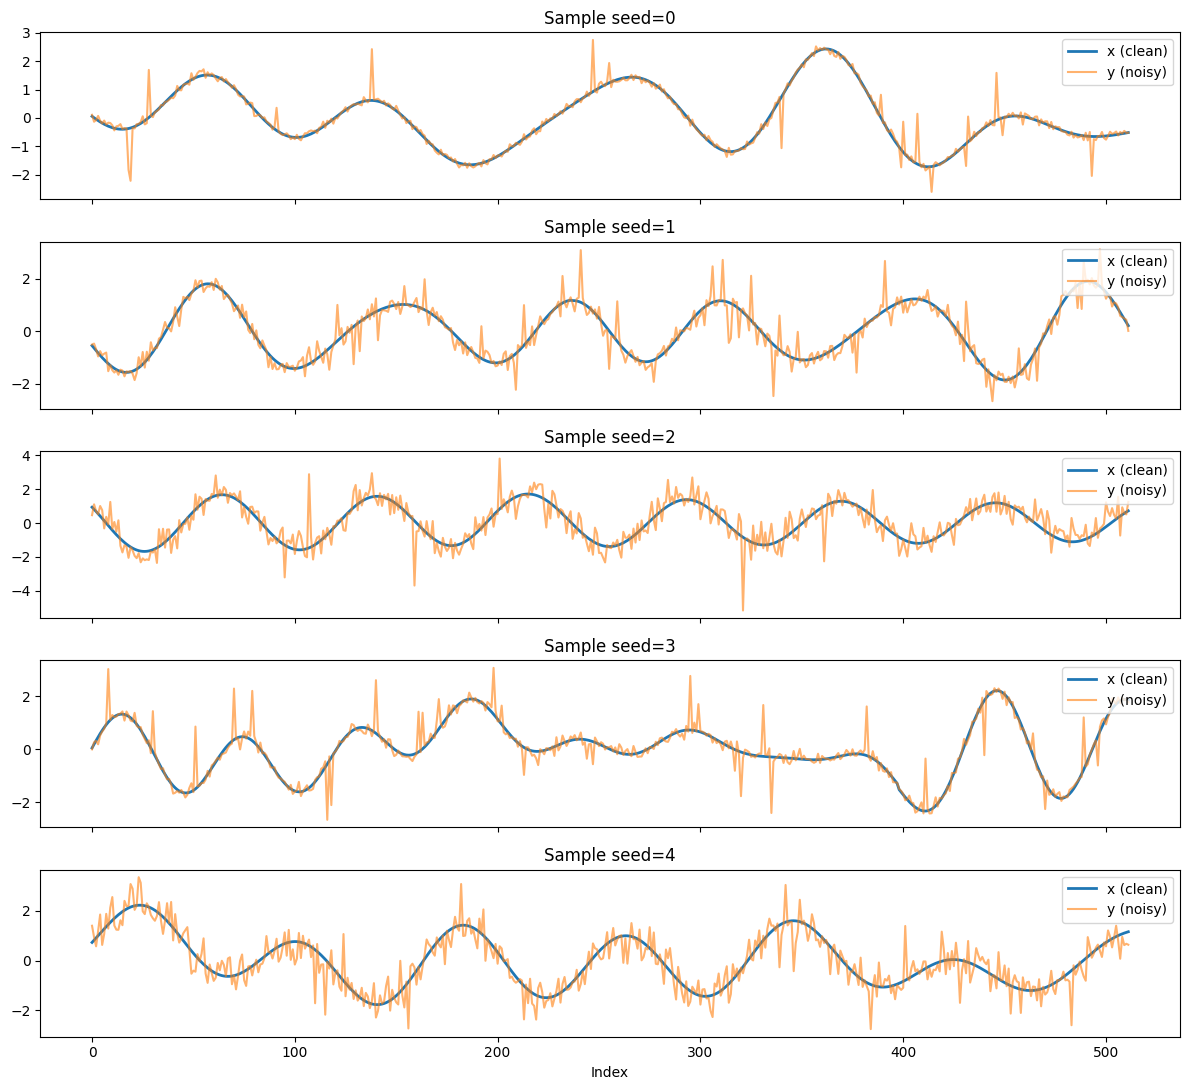

In [2]:
# Configuration des signaux synthétiques (référence commune)
cfg = Signal1DConfig(
    L=512,
    use_steps=True,
    use_spikes=True,
    do_standardize=True,
)

# Visualisation qualitative de quelques paires (x, y)
n_samples = 5
fig, axes = plt.subplots(n_samples, 1, figsize=(12, 2.2 * n_samples), sharex=True)

for i in range(n_samples):
    x_clean, y_noisy = generate_pair(cfg, seed=i)
    ax = axes[i]
    ax.plot(x_clean.numpy(), label="x (clean)", linewidth=2)
    ax.plot(y_noisy.numpy(), label="y (noisy)", alpha=0.6)
    ax.set_title(f"Sample seed={i}")
    ax.legend(loc="upper right")

plt.xlabel("Index")
plt.tight_layout()
plt.show()

## **3.3. Expérience A — Rôle du préconditionnement multi-échelles**
### **Objectif de l’expérimentation**

Cette première expérimentation vise à étudier l’impact du **préconditionnement multi-échelles** induit par le choix des projections $P_i$ et des sous-espaces $V_i$ introduits dans le cadre théorique de l’article.

L’objectif est d’évaluer dans quelle mesure l’introduction d’une approximation initiale structurée du signal :
- améliore la stabilité de l’apprentissage,
- facilite la reconstruction des structures globales,
- et permet au réseau de se concentrer sur la correction des détails locaux.

Le problème considéré est un problème de **débruitage supervisé**, où l’on cherche à approximer l’opérateur inverse $y \mapsto x$ à partir de signaux synthétiques contrôlés (Section 3.2).

### **Backbone commun $f_\theta$ (MLP résiduel)**

Pour isoler l’effet du **préconditionnement**, toutes les variantes de l’Expérience A partagent exactement le même réseau de base $f_\theta$.  
Dans le code, ce backbone correspond à `MLPResNet` (fichier `src/models/regressors.py`) instancié via `conf/model/denoiser_mlp.yaml`.

#### vArchitecture (forme et dimensions)**

Le réseau prend un signal bruité sous forme vectorielle et renvoie un vecteur de même dimension :
$$
f_\theta : \mathbb{R}^{L} \to \mathbb{R}^{L}, \qquad L = 512.
$$
En pratique, pour un batch :
$$
y \in \mathbb{R}^{B \times L} \quad \Rightarrow \quad f_\theta(y) \in \mathbb{R}^{B \times L}.
$$

Le backbone est un **MLP avec blocs résiduels** :

1. **Stem (projection vers une dimension cachée)**  
$$
h_0 = \sigma(W_{\text{in}}\, y + b_{\text{in}}), \qquad h_0 \in \mathbb{R}^{B \times H}.
$$

2. **Blocs résiduels (répétés $D$ fois)**  
Chaque bloc implémente :
$$
h \leftarrow h + g(\mathrm{LN}(h)),
$$
où $g$ est un petit MLP à deux couches linéaires avec non-linéarité (ReLU) et dropout, et où $\mathrm{LN}$ est une normalisation de couche (activée ici).

3. **Head (retour à la dimension $L$)**  
$$
f_\theta(y) = W_{\text{out}}\, h_D + b_{\text{out}} \in \mathbb{R}^{B \times L}.
$$

#### **Hyperparamètres utilisés**

- Dimension cachée : $H = 64$ (`hidden_dim=64`)
- Profondeur : $D = 2$ blocs résiduels (`depth=2`)
- Dropout : $0.05$
- LayerNorm : activée (`use_layernorm=true`)

#### **Schéma (vue compacte)**

$$
y \in \mathbb{R}^{B\times L}
\;\xrightarrow{\;\text{Linear }(L\to H)\;+\;\text{ReLU}\;}\;
h_0
\;\xrightarrow{\;\text{2 blocs résiduels}\;}\;
h_2
\;\xrightarrow{\;\text{Linear }(H\to L)\;}\;
f_\theta(y) \in \mathbb{R}^{B \times L}.
$$

Ainsi, dans l’Expérience A, **seule la manière d’utiliser $f_\theta$** change (baseline, résiduel, préconditionné), pas sa structure ni ses hyperparamètres.

### **Opérateur de débruitage appris $\hat{x}$ : baseline, résiduel, préconditionné**

Le backbone $f_\theta$ n’est pas utilisé directement de la même manière selon les variantes.  
Dans le code, c’est l’objet `DenoiserOperator` qui définit l’opérateur final $\hat{x}(y)$.

On note $y$ le signal bruité et $\hat{x}$ la reconstruction du signal propre.

#### **1) Baseline**

$$
\hat{x} = f_\theta(y).
$$

Interprétation : le réseau doit apprendre directement la reconstruction complète.

#### **2) Forme résiduelle**

$$
\hat{x} = y + f_\theta(y).
$$

Interprétation : le réseau apprend une correction additive par rapport à l’observation.

#### **3) Forme préconditionnée**

On introduit un opérateur déterministe $P$ (le préconditionneur), qui produit une approximation grossière $P(y)$.  
La reconstruction est alors :

$$
\hat{x} = P(y) + f_\theta\bigl(y - P(y)\bigr).
$$

Interprétation : $P(y)$ capture une structure simple (souvent basse fréquence), et le réseau apprend surtout le **résidu** $y - P(y)$, c’est-à-dire ce qui reste à corriger.

#### **Préconditionneurs testés dans l’Expérience A**

- **Identité** :
$$
P(y)=y.
$$
(Cas limite, utile comme point de comparaison.)

- **Moyenne glissante** (moving average) :  
$P(y)$ est un lissage par convolution 1D avec noyau uniforme de taille $k$ (ici $k=9$).  
Cela agit comme un filtre passe-bas simple.

- **Haar low-pass (niveaux $\ell$)** :  
$P(y)$ est la reconstruction basse fréquence obtenue via une décomposition de Haar tronquée à un nombre de niveaux donné (ici $\ell=1$ ou $\ell=3$).  
Cela impose explicitement une approximation multi-échelle.

#### **Schéma (vue opérateur)**

- Baseline : $y \to f_\theta \to \hat{x}$
- Résiduel : $y \to f_\theta \to$ addition avec $y \to \hat{x}$
- Préconditionné :
$$
y \xrightarrow{P} P(y),
\qquad
y \xrightarrow{-P} y-P(y) \xrightarrow{f_\theta} f_\theta(y-P(y)),
\qquad
\hat{x} = P(y) + f_\theta(y-P(y)).
$$

C’est précisément cette dernière écriture qui correspond à l’idée "approximation grossière + correction", au coeur de l’analyse multi-échelle du papier.

In [3]:
!python main.py task@_global_=regression data=signal_1d model=denoiser_mlp \
  seed=0 trainer.deterministic=true trainer.benchmark=false \
  model.model.mode=baseline model.model.preconditioner=identity \
  output_id=signal1d_baseline

Seed set to 0
seed: 0
output_dir: .cache
output_id: signal1d_baseline
trainer:
  _target_: pytorch_lightning.Trainer
  max_epochs: 15
  accelerator: auto
  log_every_n_steps: 10
  check_val_every_n_epoch: 1
  limit_val_batches: 1.0
  deterministic: true
  benchmark: false
  enable_checkpointing: true
  enable_progress_bar: true
  callbacks:
  - _target_: pytorch_lightning.callbacks.EarlyStopping
    monitor: val_loss
    mode: min
    patience: 10
  - _target_: pytorch_lightning.callbacks.ModelCheckpoint
    monitor: val_loss
    mode: min
    save_top_k: 1
    dirpath: ./${output_dir}/checkpoints
    filename: ${now:%Y-%m-%d_%H-%M-%S}-epoch={epoch}-val_loss={val_loss:.6f}
model:
  _target_: src.models.regression_model.RegressionModel
  model:
    _target_: src.models.regressors.DenoiserOperator
    mode: baseline
    preconditioner: identity
    ma_kernel_size: 9
    haar_levels: 3
    net:
      _target_: src.models.regressors.MLPResNet
      input_dim: ${data.d}
      output_dim: ${

In [4]:
!python main.py task@_global_=regression data=signal_1d model=denoiser_mlp \
  seed=0 trainer.deterministic=true trainer.benchmark=false \
  model.model.mode=residual model.model.preconditioner=identity \
  output_id=signal1d_residual

Seed set to 0
seed: 0
output_dir: .cache
output_id: signal1d_residual
trainer:
  _target_: pytorch_lightning.Trainer
  max_epochs: 15
  accelerator: auto
  log_every_n_steps: 10
  check_val_every_n_epoch: 1
  limit_val_batches: 1.0
  deterministic: true
  benchmark: false
  enable_checkpointing: true
  enable_progress_bar: true
  callbacks:
  - _target_: pytorch_lightning.callbacks.EarlyStopping
    monitor: val_loss
    mode: min
    patience: 10
  - _target_: pytorch_lightning.callbacks.ModelCheckpoint
    monitor: val_loss
    mode: min
    save_top_k: 1
    dirpath: ./${output_dir}/checkpoints
    filename: ${now:%Y-%m-%d_%H-%M-%S}-epoch={epoch}-val_loss={val_loss:.6f}
model:
  _target_: src.models.regression_model.RegressionModel
  model:
    _target_: src.models.regressors.DenoiserOperator
    mode: residual
    preconditioner: identity
    ma_kernel_size: 9
    haar_levels: 3
    net:
      _target_: src.models.regressors.MLPResNet
      input_dim: ${data.d}
      output_dim: ${

In [5]:
!python main.py task@_global_=regression data=signal_1d model=denoiser_mlp \
  seed=0 trainer.deterministic=true trainer.benchmark=false \
  model.model.mode=preconditioned model.model.preconditioner=identity \
  output_id=signal1d_precond_identity

Seed set to 0
seed: 0
output_dir: .cache
output_id: signal1d_precond_identity
trainer:
  _target_: pytorch_lightning.Trainer
  max_epochs: 15
  accelerator: auto
  log_every_n_steps: 10
  check_val_every_n_epoch: 1
  limit_val_batches: 1.0
  deterministic: true
  benchmark: false
  enable_checkpointing: true
  enable_progress_bar: true
  callbacks:
  - _target_: pytorch_lightning.callbacks.EarlyStopping
    monitor: val_loss
    mode: min
    patience: 10
  - _target_: pytorch_lightning.callbacks.ModelCheckpoint
    monitor: val_loss
    mode: min
    save_top_k: 1
    dirpath: ./${output_dir}/checkpoints
    filename: ${now:%Y-%m-%d_%H-%M-%S}-epoch={epoch}-val_loss={val_loss:.6f}
model:
  _target_: src.models.regression_model.RegressionModel
  model:
    _target_: src.models.regressors.DenoiserOperator
    mode: preconditioned
    preconditioner: identity
    ma_kernel_size: 9
    haar_levels: 3
    net:
      _target_: src.models.regressors.MLPResNet
      input_dim: ${data.d}
      

In [6]:
!python main.py task@_global_=regression data=signal_1d model=denoiser_mlp \
  seed=0 trainer.deterministic=true trainer.benchmark=false \
  model.model.mode=preconditioned model.model.preconditioner=haar model.model.haar_levels=1 \
  output_id=signal1d_precond_haar1

!python main.py task@_global_=regression data=signal_1d model=denoiser_mlp \
  seed=0 trainer.deterministic=true trainer.benchmark=false \
  model.model.mode=preconditioned model.model.preconditioner=haar model.model.haar_levels=3 \
  output_id=signal1d_precond_haar3

Seed set to 0
seed: 0
output_dir: .cache
output_id: signal1d_precond_haar1
trainer:
  _target_: pytorch_lightning.Trainer
  max_epochs: 15
  accelerator: auto
  log_every_n_steps: 10
  check_val_every_n_epoch: 1
  limit_val_batches: 1.0
  deterministic: true
  benchmark: false
  enable_checkpointing: true
  enable_progress_bar: true
  callbacks:
  - _target_: pytorch_lightning.callbacks.EarlyStopping
    monitor: val_loss
    mode: min
    patience: 10
  - _target_: pytorch_lightning.callbacks.ModelCheckpoint
    monitor: val_loss
    mode: min
    save_top_k: 1
    dirpath: ./${output_dir}/checkpoints
    filename: ${now:%Y-%m-%d_%H-%M-%S}-epoch={epoch}-val_loss={val_loss:.6f}
model:
  _target_: src.models.regression_model.RegressionModel
  model:
    _target_: src.models.regressors.DenoiserOperator
    mode: preconditioned
    preconditioner: haar
    ma_kernel_size: 9
    haar_levels: 1
    net:
      _target_: src.models.regressors.MLPResNet
      input_dim: ${data.d}
      output_

In [7]:
!python main.py task@_global_=regression data=signal_1d model=denoiser_mlp \
  seed=0 trainer.deterministic=true trainer.benchmark=false \
  model.model.mode=preconditioned model.model.preconditioner=ma model.model.ma_kernel_size=9 \
  output_id=signal1d_precond_ma9

Seed set to 0
seed: 0
output_dir: .cache
output_id: signal1d_precond_ma9
trainer:
  _target_: pytorch_lightning.Trainer
  max_epochs: 15
  accelerator: auto
  log_every_n_steps: 10
  check_val_every_n_epoch: 1
  limit_val_batches: 1.0
  deterministic: true
  benchmark: false
  enable_checkpointing: true
  enable_progress_bar: true
  callbacks:
  - _target_: pytorch_lightning.callbacks.EarlyStopping
    monitor: val_loss
    mode: min
    patience: 10
  - _target_: pytorch_lightning.callbacks.ModelCheckpoint
    monitor: val_loss
    mode: min
    save_top_k: 1
    dirpath: ./${output_dir}/checkpoints
    filename: ${now:%Y-%m-%d_%H-%M-%S}-epoch={epoch}-val_loss={val_loss:.6f}
model:
  _target_: src.models.regression_model.RegressionModel
  model:
    _target_: src.models.regressors.DenoiserOperator
    mode: preconditioned
    preconditioner: ma
    ma_kernel_size: 9
    haar_levels: 3
    net:
      _target_: src.models.regressors.MLPResNet
      input_dim: ${data.d}
      output_dim:

### **Analyse des résultats**

Les différents modèles entraînés sont comparés selon trois axes complémentaires :

- **la dynamique d’apprentissage**, à partir des courbes de perte d’entraînement et de validation ;
- **la qualité de reconstruction**, évaluée qualitativement sur des signaux synthétiques fixés ;
- **la performance quantitative**, mesurée par l’erreur quadratique moyenne, ainsi que par une décomposition fréquentielle distinguant basses et hautes fréquences.

L’ensemble des comparaisons est réalisé à configuration d’entraînement identique, afin d’isoler l’impact des choix architecturaux étudiés. Les modèles analysés correspondent, pour chaque variante, au checkpoint associé à la meilleure performance en validation.

In [8]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

CACHE_DIR = "./.cache"
LOG_DIR = os.path.join(CACHE_DIR, "lightning_logs")
CKPT_DIR = os.path.join(CACHE_DIR, "checkpoints")

RUN_VERSION = {
    "Baseline (f(y))": "version_0",
    "Residual (y + f(y))": "version_1",
    "Precond Identity": "version_2",
    "Precond Haar (L=1)": "version_3",
    "Precond Haar (L=3)": "version_4",
    "Precond MA (k=9)": "version_5",
}

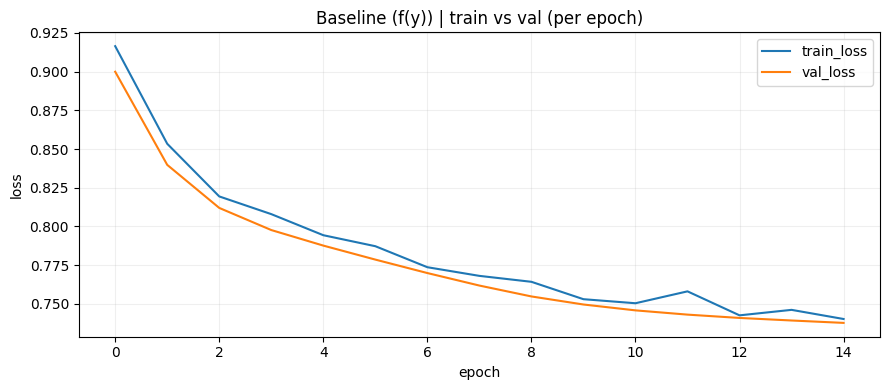

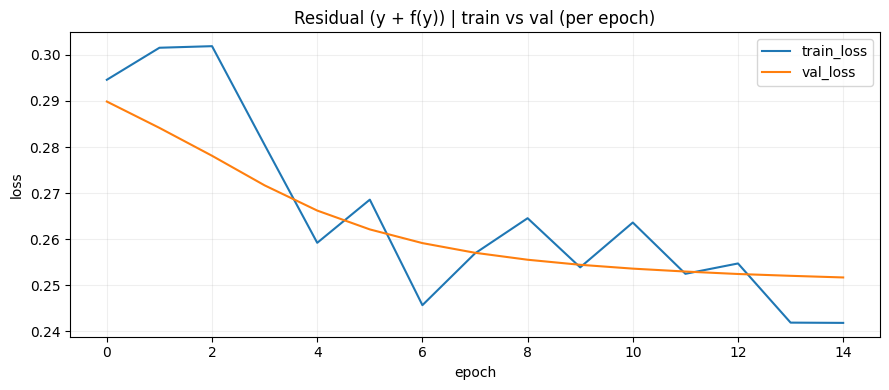

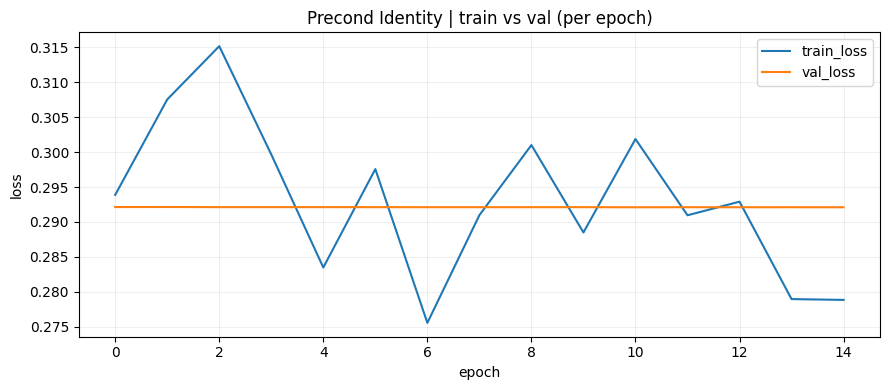

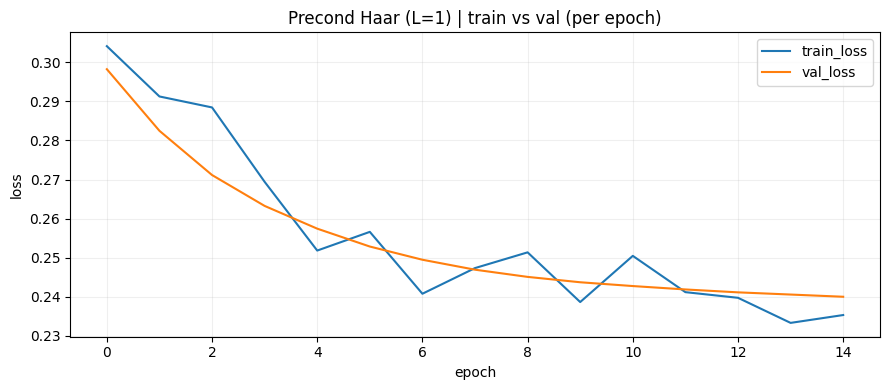

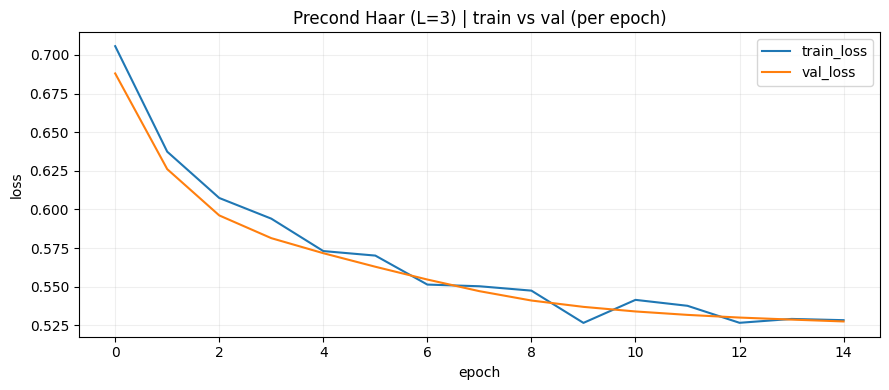

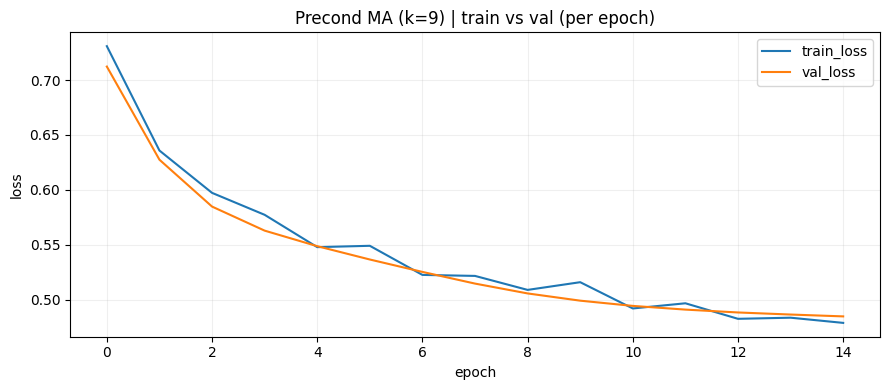

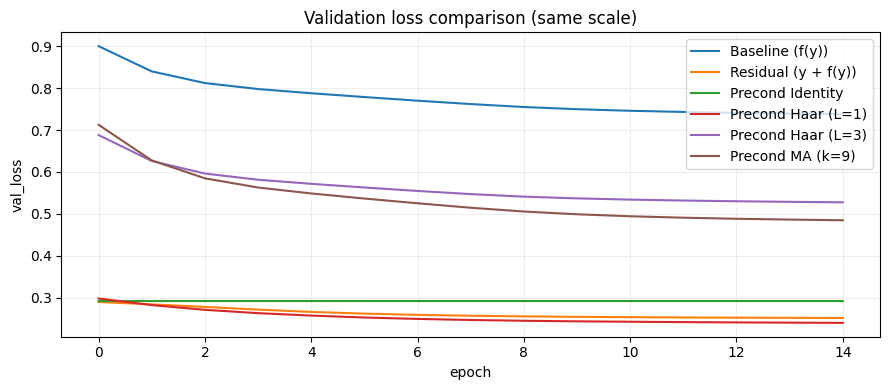

In [9]:
plot_train_val_per_model(RUN_VERSION, log_dir=LOG_DIR)
plot_val_loss_overlay(RUN_VERSION, log_dir=LOG_DIR)

### Commentaire :

In [10]:
models_info = load_best_models(
    run_version=RUN_VERSION,
    ckpt_dir=CKPT_DIR,
    log_dir=LOG_DIR,
    device=device,
)

# models_info est un dict:
# { name: {"model": ..., "ckpt": ..., "best_epoch": ..., "best_val": ... } }

for name, info in models_info.items():
    print(f"{name} | best_epoch={info['best_epoch']} | best_val={info['best_val']:.6f} | ckpt={os.path.basename(info['ckpt'])}")

Baseline (f(y)) | best_epoch=14 | best_val=0.737762 | ckpt=2026-01-27_15-36-25-epoch=epoch=14-val_loss=val_loss=0.737762.ckpt
Residual (y + f(y)) | best_epoch=14 | best_val=0.251715 | ckpt=2026-01-27_15-46-09-epoch=epoch=14-val_loss=val_loss=0.251715.ckpt
Precond Identity | best_epoch=14 | best_val=0.292101 | ckpt=2026-01-27_15-55-45-epoch=epoch=14-val_loss=val_loss=0.292101.ckpt
Precond Haar (L=1) | best_epoch=14 | best_val=0.240035 | ckpt=2026-01-27_16-05-49-epoch=epoch=14-val_loss=val_loss=0.240035.ckpt
Precond Haar (L=3) | best_epoch=14 | best_val=0.527544 | ckpt=2026-01-27_16-15-31-epoch=epoch=14-val_loss=val_loss=0.527544.ckpt
Precond MA (k=9) | best_epoch=14 | best_val=0.484730 | ckpt=2026-01-27_16-25-06-epoch=epoch=14-val_loss=val_loss=0.484730.ckpt


### Commentaire :

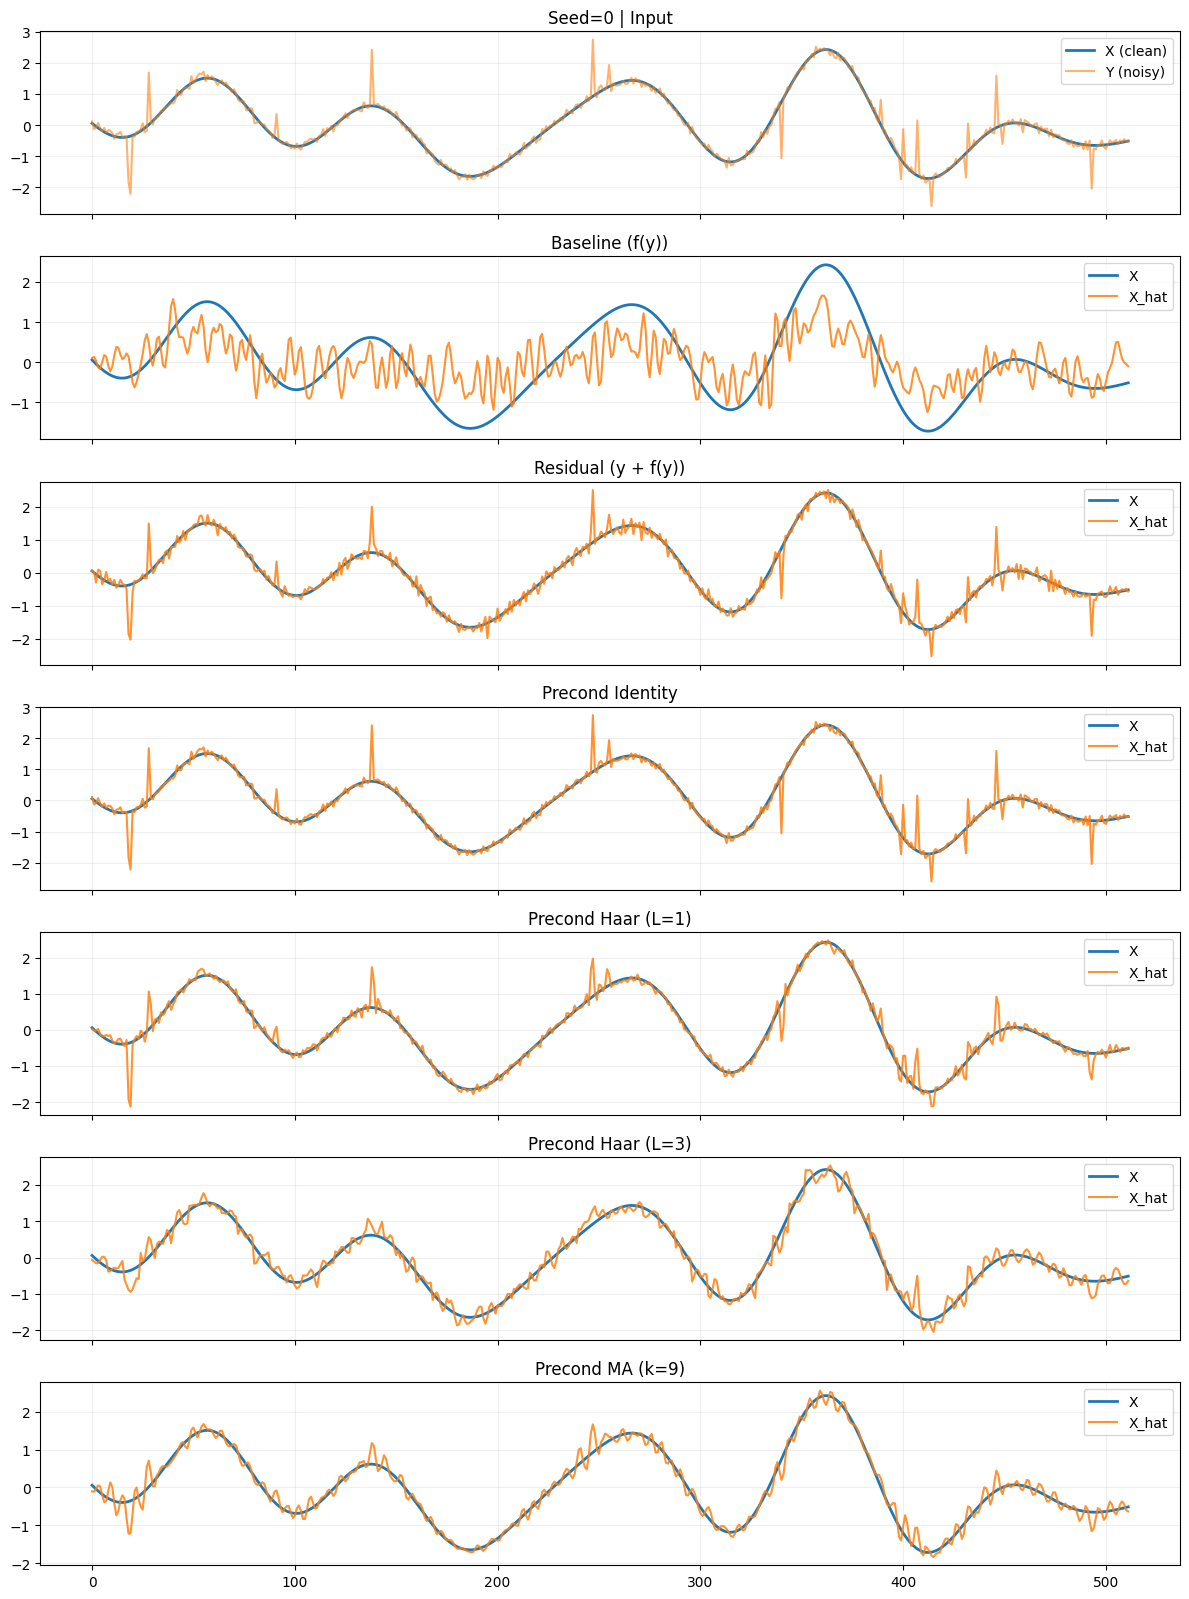

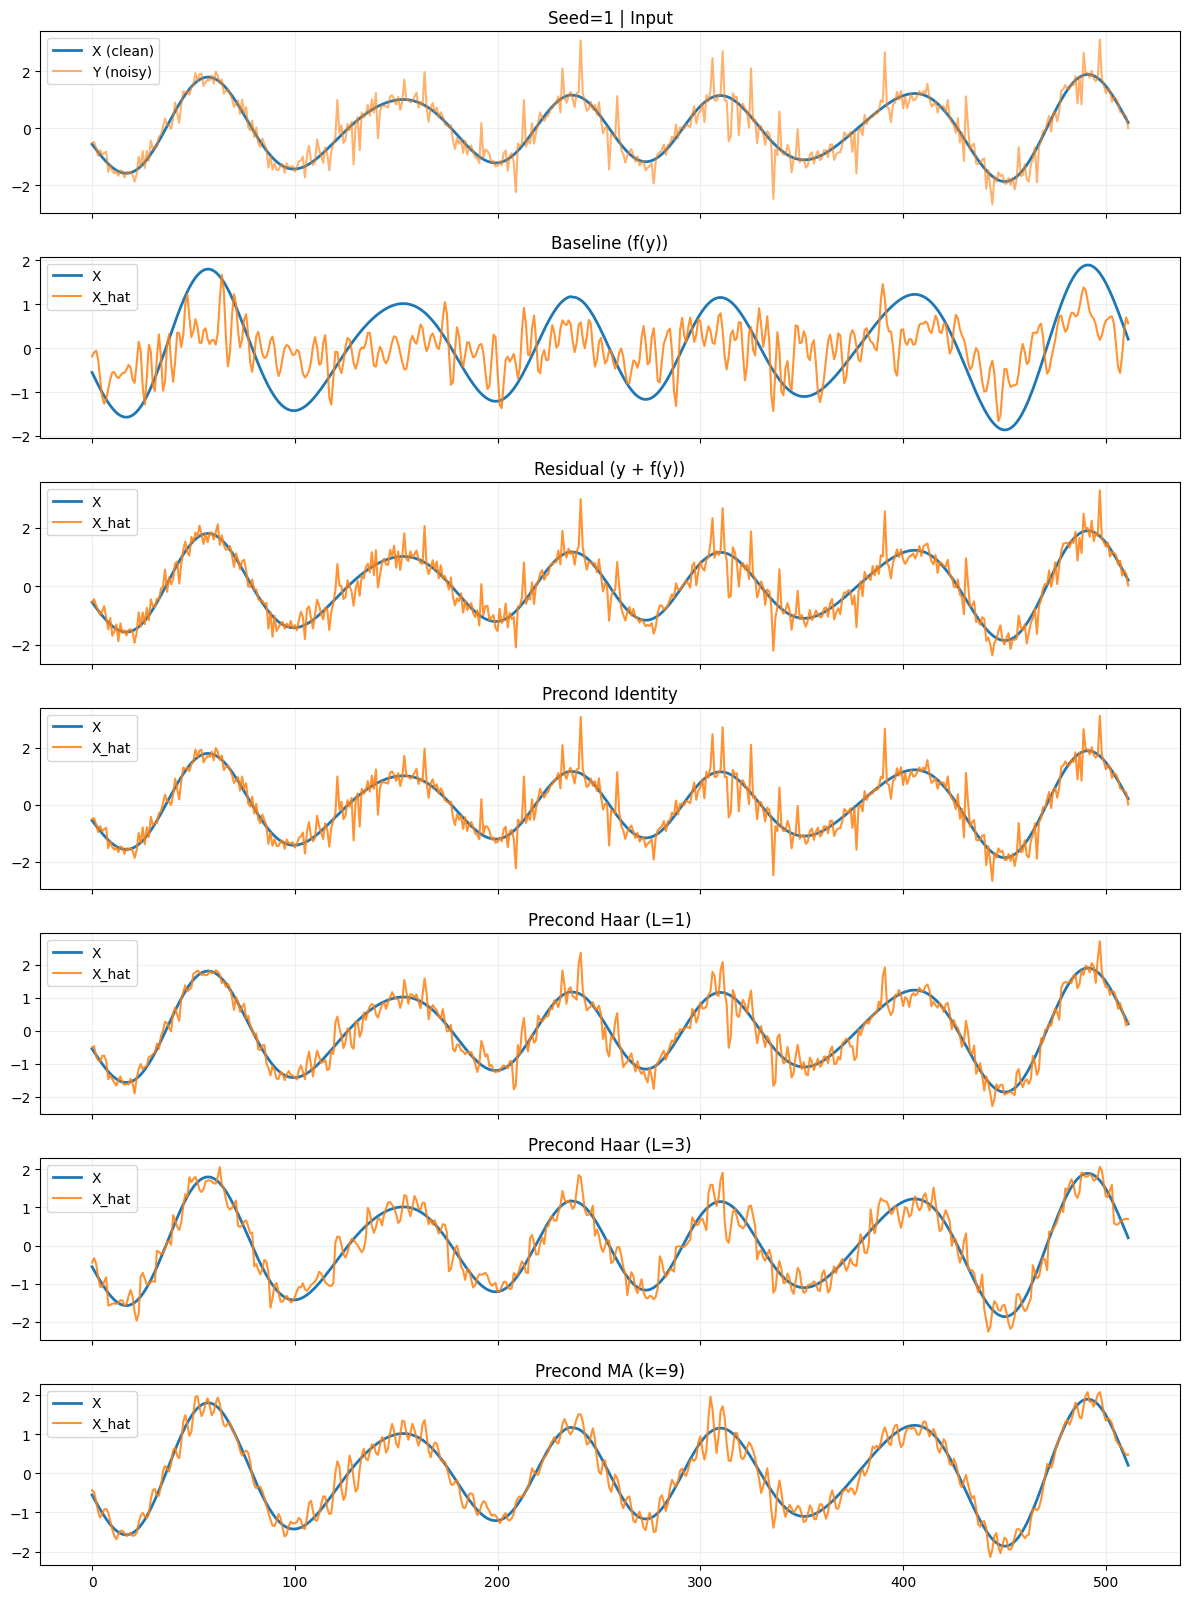

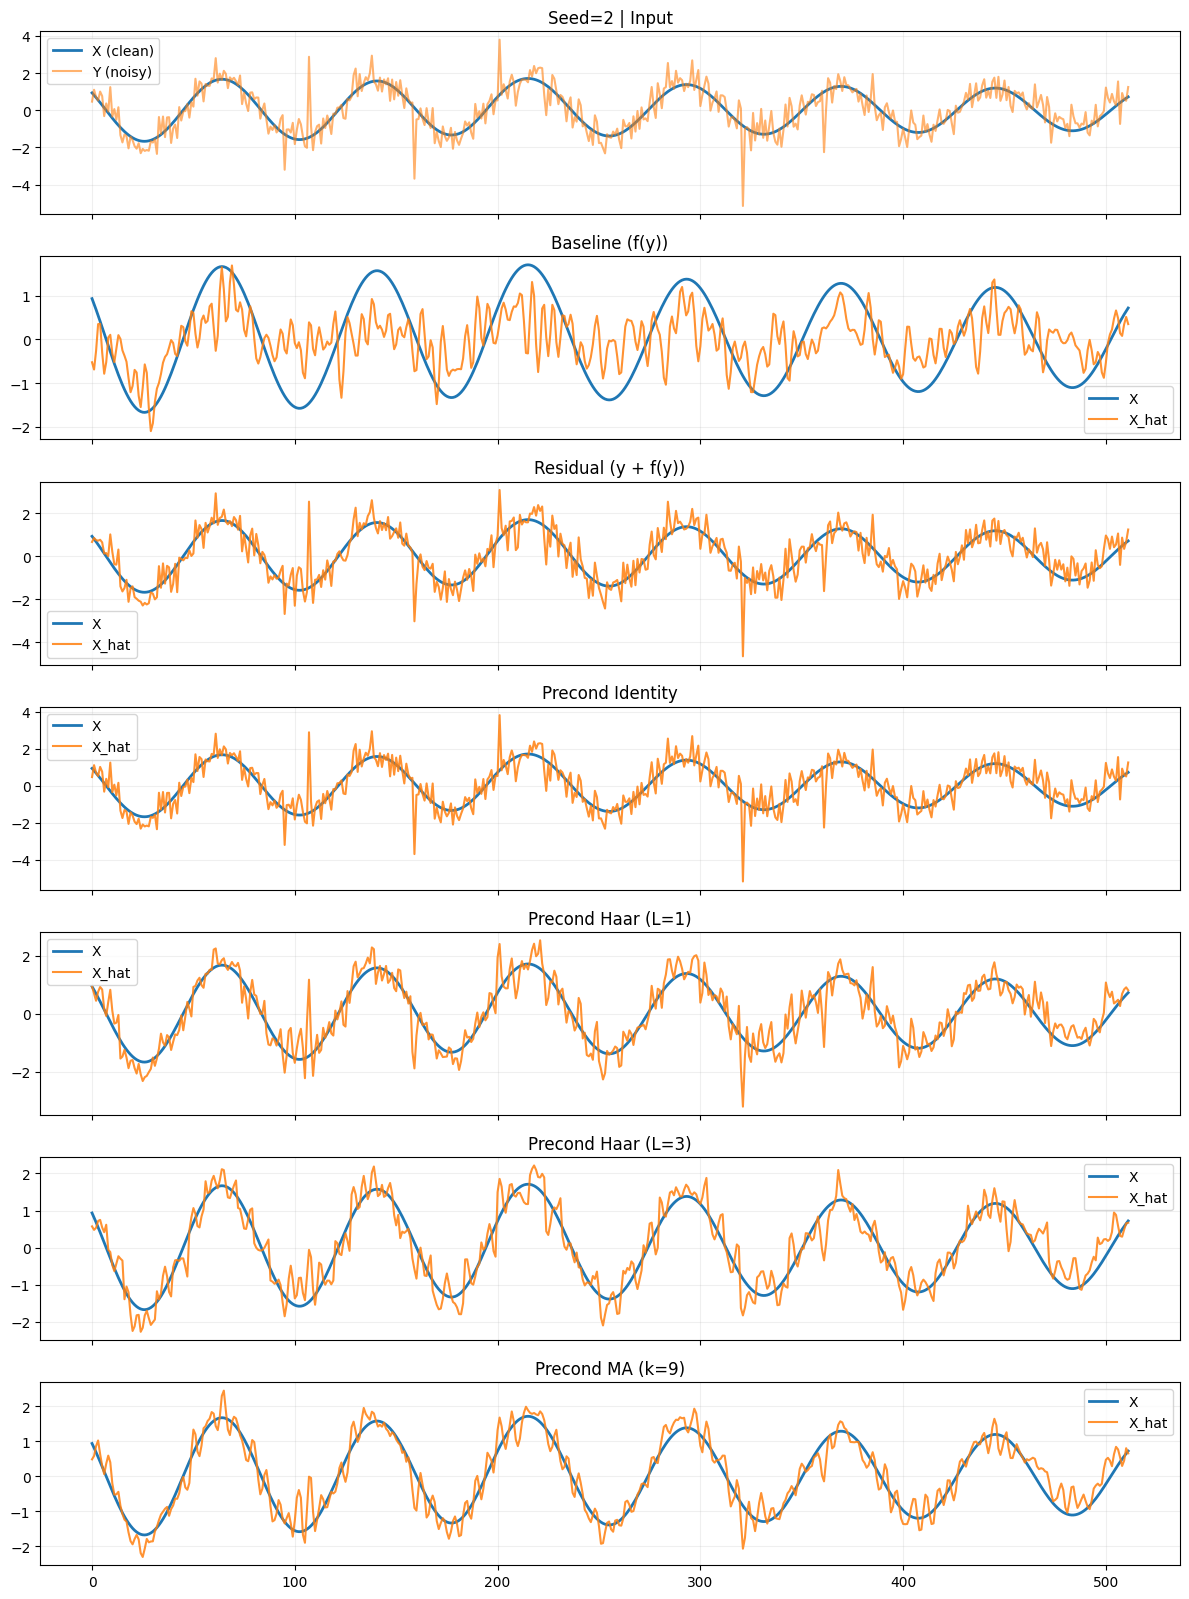

In [11]:
cfg = Signal1DConfig(L=512, use_steps=True, use_spikes=True, do_standardize=True)
seeds_visu = [0, 1, 2]

Y_fix, X_fix = fixed_batch(cfg, seeds_visu, device=device)

models = {name: info["model"] for name, info in models_info.items()}
plot_recons_clean(models, Y_fix, X_fix, seeds_visu)

### Commentaire :

In [12]:
df_eval = eval_models_lf_hf(
    models=models,
    Y=Y_fix,
    X=X_fix,
    lf_levels=3,
)

df_eval

,name,mse,mse_lf,mse_hf
0,Precond MA (k=9),0.069936,0.020801,0.049134
1,Precond Haar (L=3),0.094782,0.031830,0.062952
2,Precond Haar (L=1),0.126889,0.032015,0.094874
3,Residual (y + f(y)),0.197290,0.031141,0.166149
4,Precond Identity,0.226996,0.031818,0.195178
5,Baseline (f(y)),0.613344,0.473068,0.140276


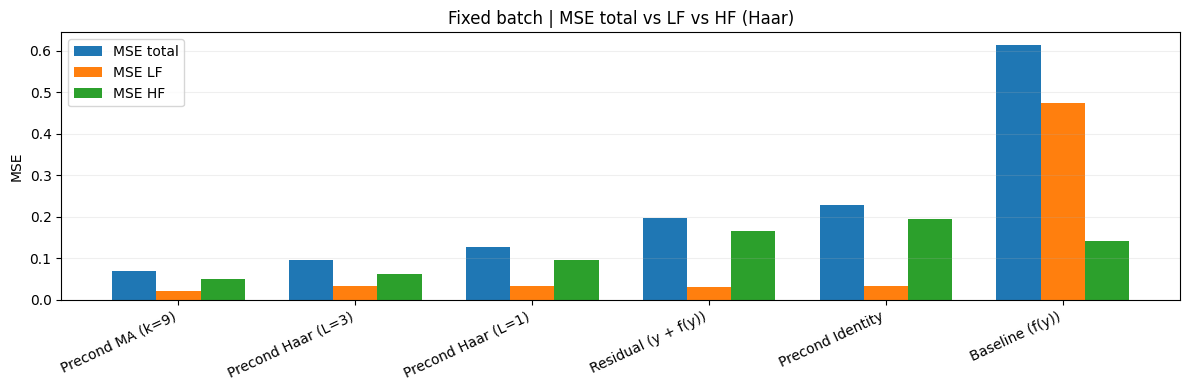

In [13]:
plot_lf_hf_bars(df_eval, title="Fixed batch | MSE total vs LF vs HF (Haar)")

### Commentaire :

## **3.5. Expérience B : rôle des connexions de saut (skip connections)**

### **Objectif**

Cette expérience isole l’effet des **connexions de saut** dans un U-Net 1D.

Deux architectures strictement identiques sont comparées, à l’exception d’un unique choix :

- **U-Net skip ON** : connexions de saut activées,
- **U-Net skip OFF** : connexions de saut désactivées (ablation).

L’objectif est d’évaluer dans quelle mesure les skip connections :
- stabilisent l’optimisation,
- améliorent la reconstruction globale,
- et affectent la répartition des erreurs entre basses et hautes fréquences.

### **Protocole**

Les deux modèles sont entraînés :
- sur exactement les mêmes données (Section 3.2),
- avec le même optimiseur et les mêmes hyperparamètres,
- et la sélection du meilleur modèle se fait via la perte de validation.

L’évaluation est ensuite effectuée :
- (i) via les courbes train/val loss,
- (ii) via une comparaison quantitative des erreurs $\mathrm{MSE}$, $\mathrm{MSE}_{\mathrm{LF}}$, $\mathrm{MSE}_{\mathrm{HF}}$,
- (iii) via quelques reconstructions qualitatives sur des signaux fixes.

Les commandes Hydra ci-dessous lancent les deux entraînements.

In [14]:
# U-Net 1D avec skip
!python main.py task@_global_=regression data=signal_1d model=denoiser_unet1d \
  seed=0 trainer.deterministic=true trainer.benchmark=false \
  model.model.skip_mode=on \
  output_id=signal1d_unet_skip_on

# U-Net 1D sans skip (ablation)
!python main.py task@_global_=regression data=signal_1d model=denoiser_unet1d \
  seed=0 trainer.deterministic=true trainer.benchmark=false \
  model.model.skip_mode=off \
  output_id=signal1d_unet_skip_off

Seed set to 0
seed: 0
output_dir: .cache
output_id: signal1d_unet_skip_on
trainer:
  _target_: pytorch_lightning.Trainer
  max_epochs: 15
  accelerator: auto
  log_every_n_steps: 10
  check_val_every_n_epoch: 1
  limit_val_batches: 1.0
  deterministic: true
  benchmark: false
  enable_checkpointing: true
  enable_progress_bar: true
  callbacks:
  - _target_: pytorch_lightning.callbacks.EarlyStopping
    monitor: val_loss
    mode: min
    patience: 10
  - _target_: pytorch_lightning.callbacks.ModelCheckpoint
    monitor: val_loss
    mode: min
    save_top_k: 1
    dirpath: ./${output_dir}/checkpoints
    filename: ${now:%Y-%m-%d_%H-%M-%S}-epoch={epoch}-val_loss={val_loss:.6f}
model:
  _target_: src.models.regression_model.RegressionModel
  model:
    _target_: src.models.unet_1d.UNet1D
    in_channels: 1
    out_channels: 1
    dims:
    - 32
    - 64
    - 128
    - 256
    skip_mode: 'on'
  loss:
    _target_: torch.nn.MSELoss
  optimizer:
    _target_: torch.optim.AdamW
    lr: 0.0

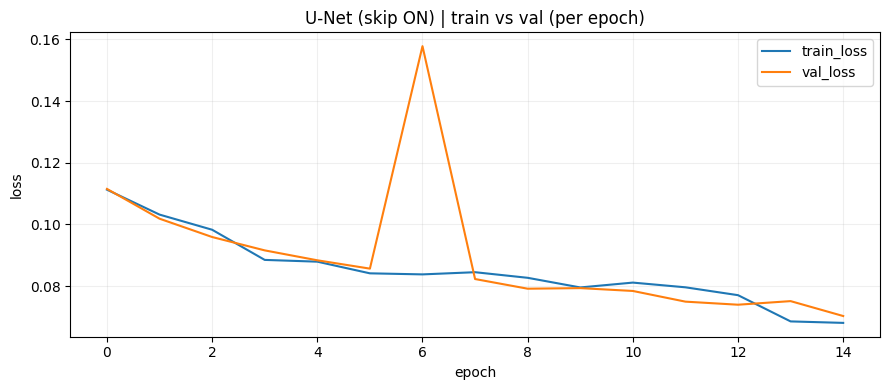

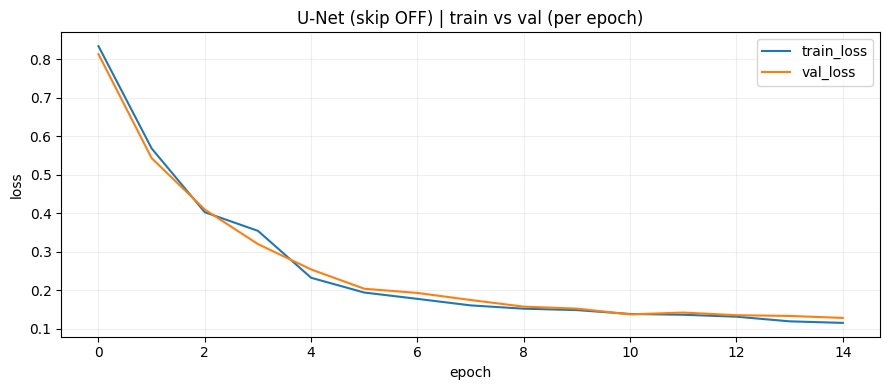

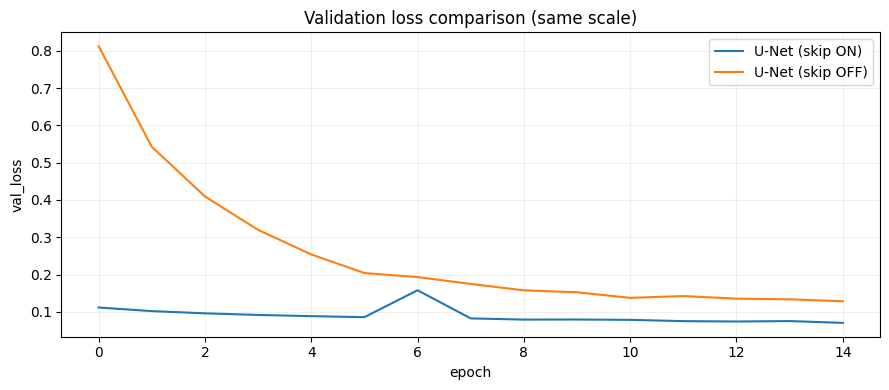

In [15]:
RUN_VERSION2 = {
    "U-Net (skip ON)":  "version_6",
    "U-Net (skip OFF)": "version_7",
}
plot_train_val_per_model(RUN_VERSION2, log_dir=LOG_DIR)
plot_val_loss_overlay(RUN_VERSION2, log_dir=LOG_DIR)

In [16]:
models_info = load_best_models(
    run_version=RUN_VERSION2,
    ckpt_dir=CKPT_DIR,
    log_dir=LOG_DIR,
    device=device,
)

# models_info est un dict:
# { name: {"model": ..., "ckpt": ..., "best_epoch": ..., "best_val": ... } }

for name, info in models_info.items():
    print(f"{name} | best_epoch={info['best_epoch']} | best_val={info['best_val']:.6f} | ckpt={os.path.basename(info['ckpt'])}")

U-Net (skip ON) | best_epoch=14 | best_val=0.070272 | ckpt=2026-01-27_16-34-42-epoch=epoch=14-val_loss=val_loss=0.070272.ckpt
U-Net (skip OFF) | best_epoch=14 | best_val=0.128336 | ckpt=2026-01-27_16-54-24-epoch=epoch=14-val_loss=val_loss=0.128336.ckpt


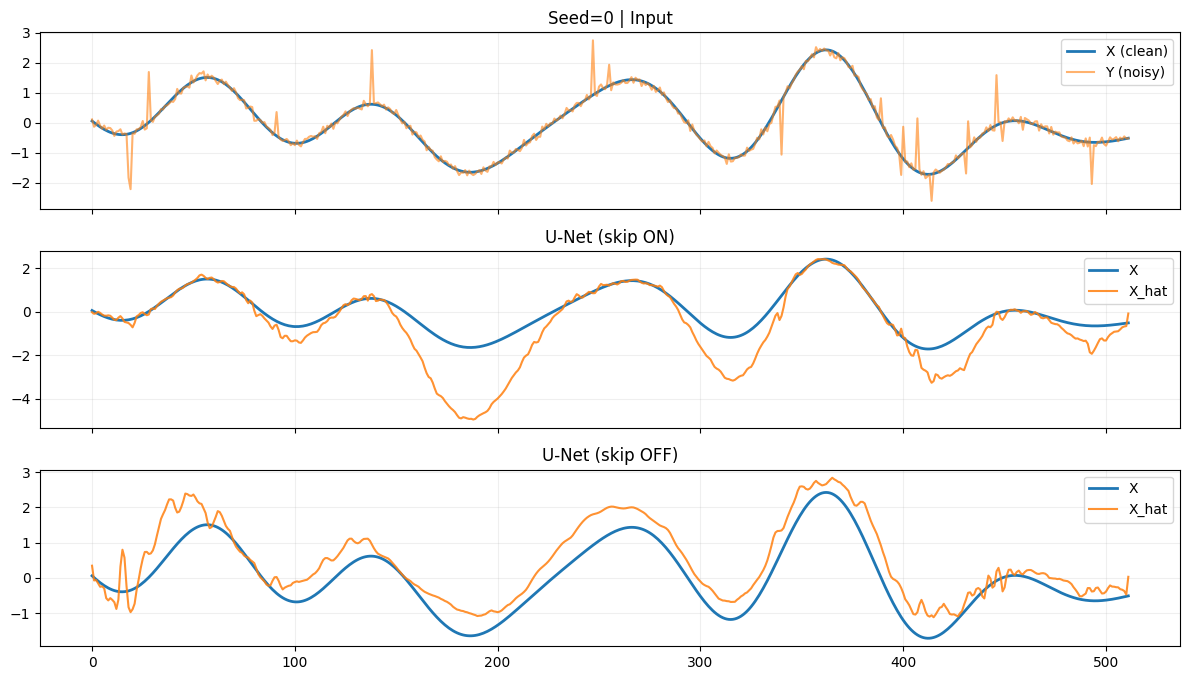

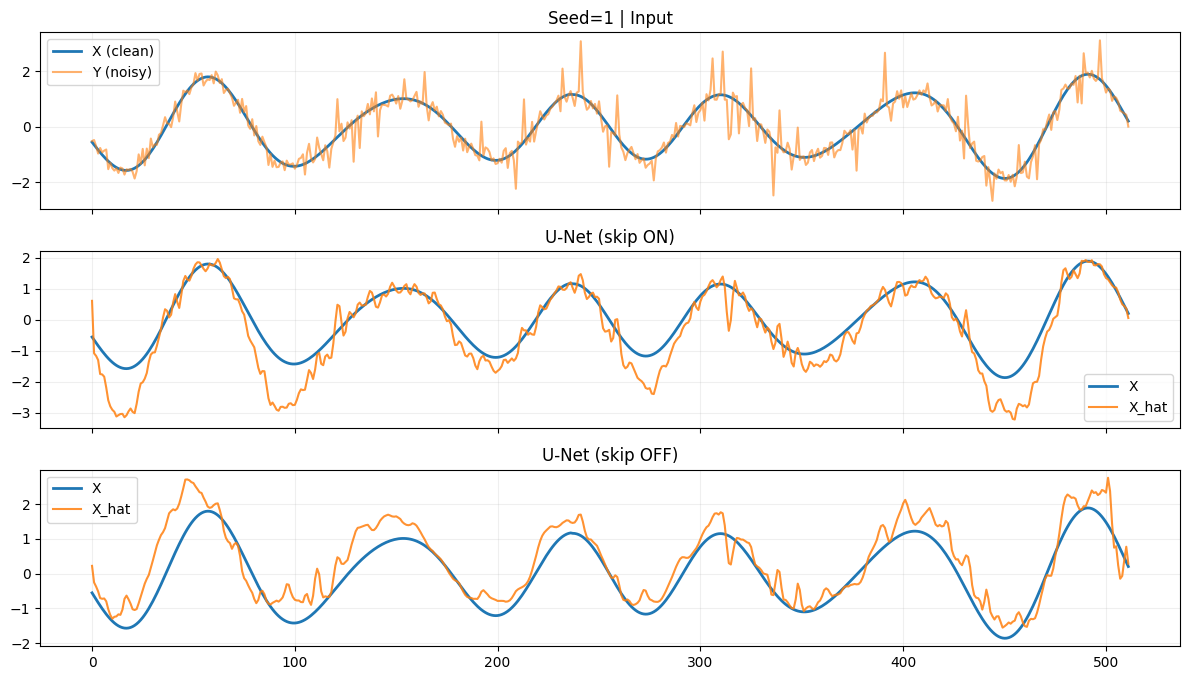

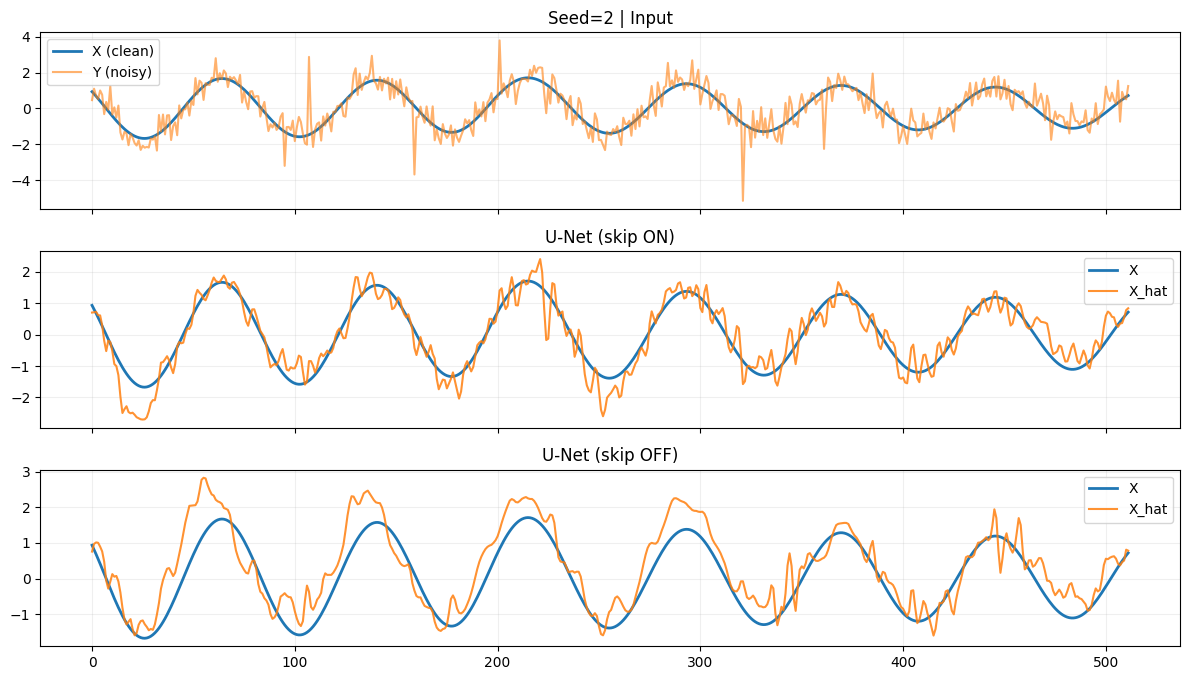

In [17]:
cfg = Signal1DConfig(L=512, use_steps=True, use_spikes=True, do_standardize=True)
seeds_visu = [0, 1, 2]

Y_fix, X_fix = fixed_batch(cfg, seeds_visu, device=device)

models = {name: info["model"] for name, info in models_info.items()}
plot_recons_clean(models, Y_fix, X_fix, seeds_visu)

In [18]:
df_eval = eval_models_lf_hf(
    models=models,
    Y=Y_fix,
    X=X_fix,
    lf_levels=3,
)

df_eval

,name,mse,mse_lf,mse_hf
0,U-Net (skip OFF),0.314173,0.275478,0.038695
1,U-Net (skip ON),0.554477,0.500994,0.053483


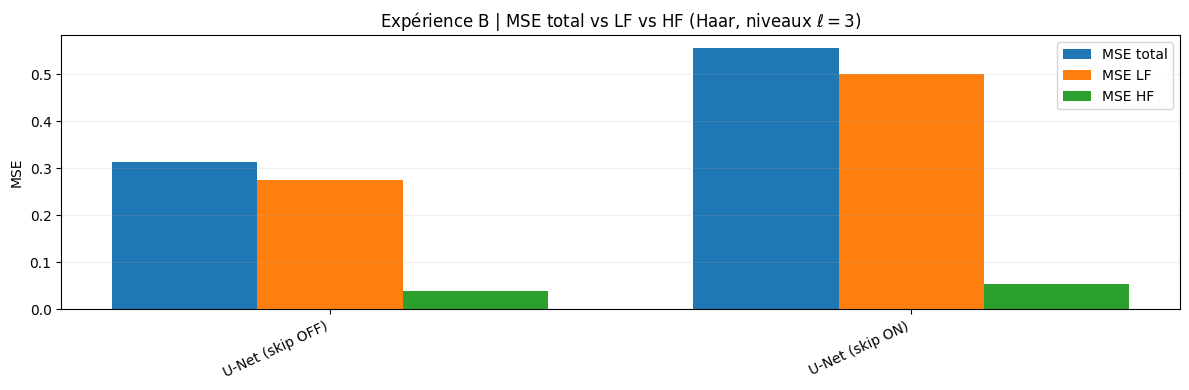

In [19]:
plot_lf_hf_bars(df_eval, title="Expérience B | MSE total vs LF vs HF (Haar, niveaux $\\ell=3$)")

#### **Résultats et analyse — Expérience B**

Les résultats mettent en évidence un impact majeur des connexions de saut :

- le modèle sans connexions de saut présente une perte de précision notable sur les basses fréquences,
- les reconstructions sont plus lissées et peinent à restituer correctement les structures locales,
- le modèle avec connexions de saut conserve une meilleure fidélité aux signaux propres, tant sur les basses que sur les hautes fréquences.

Ces observations confirment expérimentalement l’interprétation théorique des connexions de saut comme mécanisme de **transmission directe d’informations fines** entre niveaux de résolution compatibles.

#### **Discussion synthétique**

Ces deux expérimentations mettent en évidence que :

- le **préconditionnement multi-échelles** constitue un levier central pour stabiliser l’apprentissage et structurer la reconstruction,
- les **connexions de saut** sont essentielles pour préserver l’information de haute résolution lors de la phase de décodage.

Pris ensemble, ces résultats fournissent une validation empirique, sur données contrôlées, des principes théoriques développés dans l’article, et motivent leur utilisation dans des contextes plus réalistes.